# An analysis of Applications on Google Play Store


In [27]:
#Imports and Dependencies 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns 
color = sns.color_palette()
sns.set(rc={'figure.figsize':(20,10)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf
% matplotlib inline

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler  

import warnings
warnings.filterwarnings('ignore')

In [28]:
#Data Import
file = r'C:\Users\msastry\Desktop\Data Sets\ToGit\Play Store Analytics\Data\googleplaystore.csv'
df = pd.read_csv(file)
df.drop_duplicates(subset='App', inplace=True)
print('Number of Applications in the Data Set:', len(df))

Number of Applications in the Data Set: 9660


In [29]:
#Eliminating stray entries in the 'Installs' and 'Android Ver' columns 
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']

In [30]:
#Data Cleaning
#Removing , + M K and $ Symbols + All type conversions

#'Installs' Column
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: float(x))
#'Size' Column
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))
#'Price' Column
df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))
#'Reviews' Column
df['Reviews'] = df['Reviews'].apply(lambda x: int(x))


In [31]:
df.sample(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
7158,Mirror,LIFESTYLE,4.1,367505,NaN,10000000.0,Free,0.00,Everyone,Lifestyle,25-Jul-18,Varies with device,Varies with device
8657,"Robinhood - Investing, No Fees",FINANCE,4.6,57493,NaN,1000000.0,Free,0.00,Everyone,Finance,31-Jul-18,Varies with device,Varies with device
7845,ORLANDO FLORIDA MAP,TRAVEL_AND_LOCAL,NaN,3,9.20,1000.0,Free,0.00,Everyone,Travel & Local,24-Jan-17,1.3.0,4.0 and up
3657,Dr. Cares - Pet Rescue 911 🐶,FAMILY,4.2,14432,35.00,500000.0,Free,0.00,Everyone,Casual,21-Sep-17,1.5,4.0.3 and up
1127,Bacterial Vaginosis Treatment,MEDICAL,NaN,0,3.40,50.0,Free,0.00,Everyone,Medical,25-Jun-18,1,4.0 and up
1232,BC Camera,PHOTOGRAPHY,4.2,5,5.50,500.0,Free,0.00,Everyone,Photography,10-Jan-18,1,4.0.3 and up
9455,"SweetRing - Meet, Match, Date",DATING,4.0,51698,63.00,1000000.0,Free,0.00,Mature 17+,Dating,26-Jul-18,3.0.0,4.0.3 and up
6216,iOBD2-CF,TOOLS,3.4,5,21.00,500.0,Free,0.00,Everyone,Tools,26-Dec-16,1,2.3.3 and up
8405,Quiz TRUE or FALSE,GAME,4.6,2464,34.00,50000.0,Free,0.00,Everyone,Trivia,13-Feb-18,1.1,4.1 and up
316,Advanced EX for KIA,TOOLS,3.3,257,0.16,5000.0,Paid,4.99,Everyone,Tools,14-Mar-15,1.4,1.6 and up


In [32]:
#Overview of the data - Pie Plot of Categories and App Count 
categories = df['Category'].value_counts()

pie_chart = [go.Pie(
        labels = categories.index,
        values = categories.values,
        hoverinfo = 'value + label'
    
)]

layout = go.Layout(title = 'Distribution of Apps across Categories')

print('Total number of categories:', categories.count())
print('Count by categories:')
print(categories)
toPlot = go.Figure(data = pie_chart, layout = layout)

#Please refer to the Results section of the Kernel to find the plot
plotly.offline.plot(toPlot, filename='Pie Chart')

Total number of categories: 33
Count by categories:
FAMILY                 1832
GAME                    959
TOOLS                   827
BUSINESS                420
MEDICAL                 395
PERSONALIZATION         376
PRODUCTIVITY            374
LIFESTYLE               369
FINANCE                 345
SPORTS                  325
COMMUNICATION           315
HEALTH_AND_FITNESS      288
PHOTOGRAPHY             281
NEWS_AND_MAGAZINES      254
SOCIAL                  239
BOOKS_AND_REFERENCE     222
TRAVEL_AND_LOCAL        219
SHOPPING                202
DATING                  171
VIDEO_PLAYERS           163
MAPS_AND_NAVIGATION     131
EDUCATION               119
FOOD_AND_DRINK          112
ENTERTAINMENT           102
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       84
WEATHER                  79
HOUSE_AND_HOME           74
EVENTS                   64
ART_AND_DESIGN           64
PARENTING                60
COMICS                   56
BEAUTY                   53
Name: Category, dtype: i

'file://C:\\Users\\msastry\\Pie Chart.html'

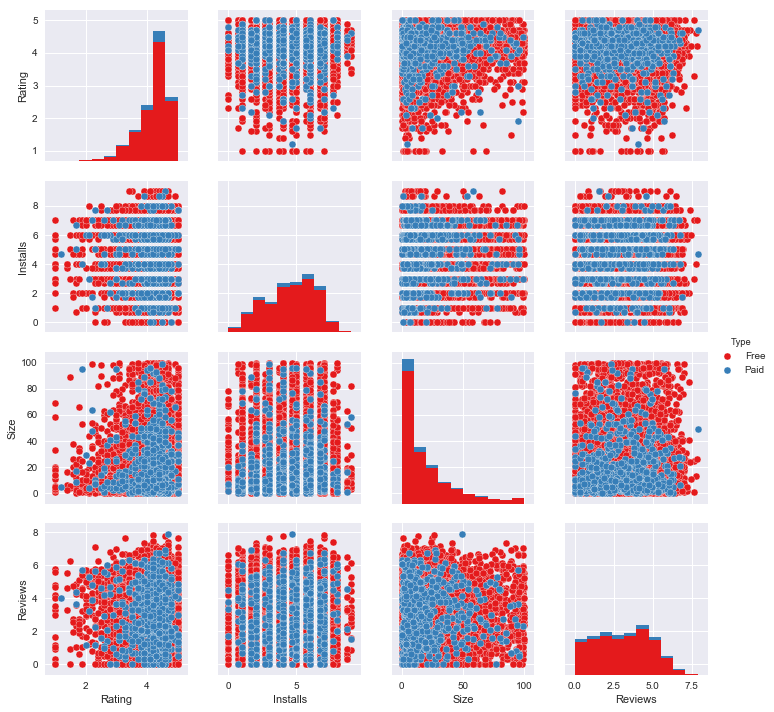

In [33]:
#Pairwise Plot of Numeric Features 

rating = df['Rating'].dropna()
size = df['Size'].dropna()
installs = df['Installs'][df.Installs!=0].dropna()
reviews = df['Reviews'][df.Reviews!=0].dropna()
type = df['Type'].dropna()
pairplot = sns.pairplot(pd.DataFrame(list(zip(rating, np.log10(installs), size, np.log10(reviews), type)),
                                     columns=['Rating', 'Installs', 'Size','Reviews', 'Type']), hue='Type', palette="Set1")



<Figure size 720x720 with 0 Axes>

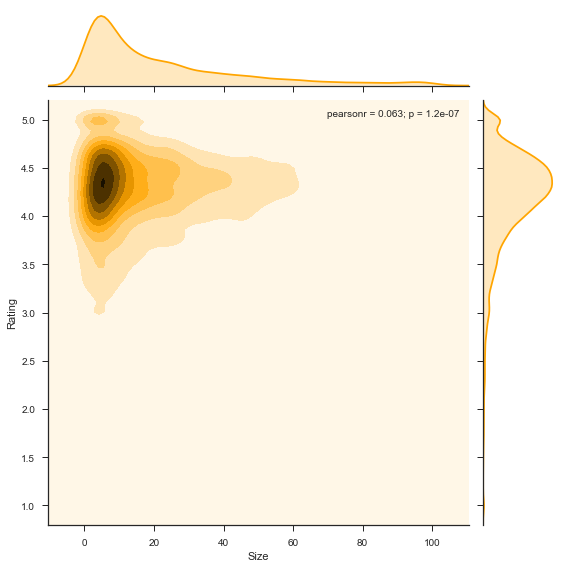

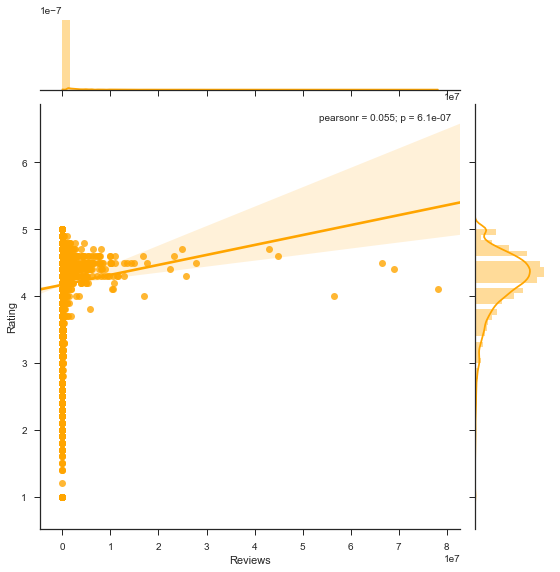

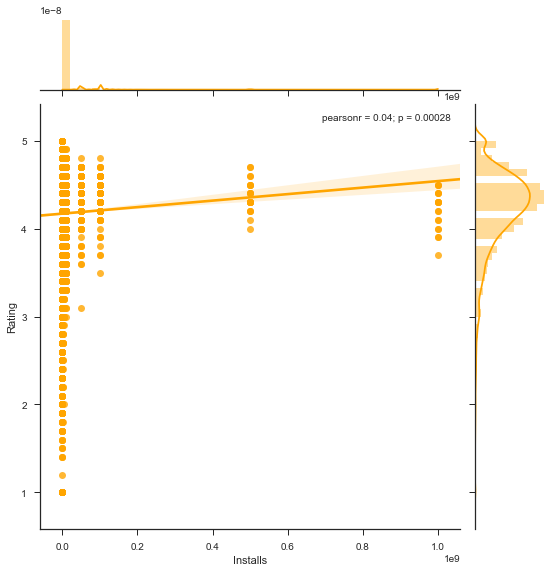

In [34]:
#Further Analysis using Join Plots
sns.set_style("ticks")
plt.figure(figsize = (10,10))
size_vs_rating = sns.jointplot(df['Size'], df['Rating'], kind = 'kde', color = "orange", size = 8)
review_vs_rating = sns.jointplot(df['Reviews'], df['Rating'], kind = 'reg', color = "orange", size = 8)
installs_vs_rating = sns.jointplot(df['Installs'], df['Rating'], kind ='reg', color = "orange", size = 8)


In [35]:
#Box Plot of Category and Avergae App Rating
print('Average App Rating = ', np.nanmean(df['Rating']))
print('Category vs. Avg Rating')
data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'box',
    'name' : category,
    'showlegend' : False
    } for i,category in enumerate(list(set(df['Category'])))]

layout = {'title' : 'App ratings across major categories',
        'xaxis': {'tickangle':-40},
        'yaxis': {'title': 'Rating'}
         }
toPlot = go.Figure(data = data, layout = layout)
#Please refer to the Results section of the Kernel to find the plot
plotly.offline.plot(toPlot,filename = "BoxPlot")

Average App Rating =  4.173243045387994
Category vs. Avg Rating


'file://C:\\Users\\msastry\\BoxPlot.html'

# A simple Regression Model to define and predict the Range of the Ratings for the Applications(Exploratory only)

In [36]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,"""i DT"" Fútbol. Todos Somos Técnicos.",SPORTS,NaN,27,3.600,500.0,Free,0.0,Everyone,Sports,7-Oct-17,0.22,4.1 and up
1,.R,TOOLS,4.5,259,0.203,10000.0,Free,0.0,Everyone,Tools,16-Sep-14,1.1.06,1.5 and up
2,/u/app,COMMUNICATION,4.7,573,53.000,10000.0,Free,0.0,Mature 17+,Communication,3-Jul-18,4.2.4,4.1 and up
3,[adult swim],FAMILY,3.6,21433,21.000,1000000.0,Free,0.0,Mature 17+,Entertainment,29-May-18,3.0.1805181047,5.0 and up
4,[BN] Blitz,SPORTS,3.2,4,5.600,100.0,Free,0.0,Everyone,Sports,17-May-18,4.6,4.3 and up


In [37]:
#Discard insignificant features
df.drop(['App', 'Last Updated', 'Current Ver'], 1, inplace = True)

In [38]:
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,SPORTS,NaN,27,3.600,500.0,Free,0.0,Everyone,Sports,4.1 and up
1,TOOLS,4.5,259,0.203,10000.0,Free,0.0,Everyone,Tools,1.5 and up
2,COMMUNICATION,4.7,573,53.000,10000.0,Free,0.0,Mature 17+,Communication,4.1 and up
3,FAMILY,3.6,21433,21.000,1000000.0,Free,0.0,Mature 17+,Entertainment,5.0 and up
4,SPORTS,3.2,4,5.600,100.0,Free,0.0,Everyone,Sports,4.3 and up


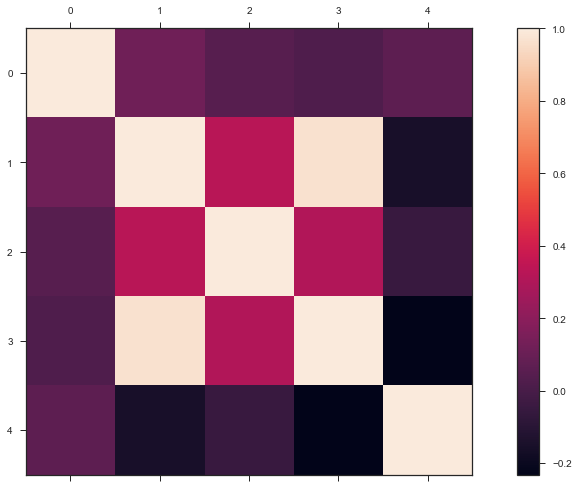

In [39]:
#Feature correlation matrix
fig = plt.figure(figsize = (16,8))
#corr = plt.matshow(df.apply(lambda x:pd.factorize(x)[0]).corr(), fignum = 1)
corr = df.corr(method = 'spearman', min_periods = 5)
plot = plt.matshow(corr, fignum = 1)
fig.colorbar(plot)

In [40]:
#Conversion of categorical variables to numeric variables - one hot encoding (manual)
new_df = pd.get_dummies(df, columns = ['Category', 'Content Rating', 'Genres', 'Android Ver', 'Type'])
new_df.head()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,...,Android Ver_5.0 and up,Android Ver_5.1 and up,Android Ver_6.0 and up,Android Ver_7.0 - 7.1.1,Android Ver_7.0 and up,Android Ver_7.1 and up,Android Ver_8.0 and up,Android Ver_Varies with device,Type_Free,Type_Paid
0,NaN,27,3.600,500.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4.5,259,0.203,10000.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4.7,573,53.000,10000.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3.6,21433,21.000,1000000.0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,3.2,4,5.600,100.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
new_df.replace('?', -9999, inplace = True )
new_df.dropna(inplace = True)

In [42]:
new_df.head()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,...,Android Ver_5.0 and up,Android Ver_5.1 and up,Android Ver_6.0 and up,Android Ver_7.0 - 7.1.1,Android Ver_7.0 and up,Android Ver_7.1 and up,Android Ver_8.0 and up,Android Ver_Varies with device,Type_Free,Type_Paid
1,4.5,259,0.203,10000.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4.7,573,53.000,10000.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3.6,21433,21.000,1000000.0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,3.2,4,5.600,100.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,3.9,6736,0.072,500000.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
X = np.array(new_df.drop(['Rating'],1))
y = np.array(new_df['Rating'])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.3)

In [44]:
#Feature scaling 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
y_pred = regressor.predict(X_test)

In [47]:
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})  
print('Simple Regression Results')
print(result.head())  

Simple Regression Results
   Actual  Predicted
0     3.8   3.926421
1     4.3   4.373687
2     5.0   4.078033
3     3.9   4.253570
4     3.8   4.058257


In [48]:
#Predictions with XGBoost 
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=70, learning_rate=0.08, gamma=0, subsample=0.70,
                           colsample_bytree=1, max_depth=7)

In [49]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=70,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [50]:
import math
print("RMSE: %.2f"
      % math.sqrt(np.mean((model.predict(X_test) - y_test) ** 2)))

RMSE: 0.52


In [51]:
y_pred1 = model.predict(X_test)
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred1})  
result.head()  

,Actual,Predicted
0,3.8,3.897138
1,4.3,3.910531
2,5.0,4.036624
3,3.9,4.125656
4,3.8,3.977031


Fine tuning the prediction - by introducing a range

In [52]:
#Introducing a range for the predicted Ratings

diff_list = abs(result['Predicted']-result['Actual'])
mean_diff = np.nanmean(diff_list)
variance = np.square(diff_list-mean_diff).sum()/len(diff_list)
standard_deviation = np.sqrt(variance)
lower_bound = np.around(y_pred - (standard_deviation),2)
upper_bound = np.around(y_pred + (standard_deviation),2)

In [53]:
result_final = pd.DataFrame({'Actual Rating':y_test, 'Lower Bound on Predicted Rating': lower_bound, 'Upper Bound on Predicted Rating': upper_bound })
result_final.sample(10)

,Actual Rating,Lower Bound on Predicted Rating,Upper Bound on Predicted Rating
567,4.1,3.59,4.34
1786,4.6,3.61,4.36
1216,4.1,3.55,4.30
503,4.2,3.81,4.56
866,4.7,3.73,4.48
599,4.2,4.11,4.85
576,4.6,3.86,4.60
17,5.0,3.82,4.57
1448,3.3,3.69,4.43
746,4.4,3.60,4.35
